# INLS 613 Final Project: Fake News

## 1: Data

### 1.1: Read in Data

In [15]:
import pandas as pd
import numpy as np
import scipy

In [16]:
df = pd.read_csv("fake_or_real_news.csv/fake_or_real_news.csv",encoding='utf-8')

In [17]:
df['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [18]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [19]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [20]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## 2: Split Train and Test Data

### 2.1: Drop Extra Columns from DataFrame

In [21]:
df_x=df.drop(['label'], axis=1)

In [22]:
df_x=df_x.drop(df.columns[0], axis=1)

In [23]:
df_x.head()

,title,text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...


### 2.2: Convert Y Labels

In [24]:
from sklearn import preprocessing ### Importing a preprocessor to convert the labels in the target class. 

In [25]:
data_class_y= [ 'FAKE', 'REAL']
le= preprocessing.LabelEncoder()
le.fit(data_class_y)
#y should now be an array of labels where 0 is FAKE and 1 is REAL
y=le.transform(df['label']);

In [27]:
le.transform(['FAKE', 'REAL'])

array([0, 1], dtype=int64)

Note that "FAKE" is encoded as 0 and 'REAL' is encoded as 1

### 2.3: Split Data

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_x, test_x, train_y, test_y = train_test_split(df_x, y, train_size=.8, random_state=5)

## 3: Preprocessing

### 3.1: Downcase

In [30]:
# lower takes in an array of strings and converts every string to all lower case
def lower(arr):
    out=[]
    for i in range(len(arr)):
        out.append(arr[i].lower())
    return out;

### 3.2: Remove Terms (stop words and numbers)

Call functions to remove stop words and downcase. Store results in "processed_text" and "processed_title"

In [31]:
import nltk
from nltk.corpus import stopwords
def remove_stops(s):
    word_list = s.split(" ");
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return " ".join(filtered_words)

def remove_all_stops(a):
    out=[]
    for i in range(len(a)):
        out.append(remove_stops(a[i]))
    return out
def remove_numbers(s):
    out=[]
    for i in s:
        if not i.isdigit():
            out.append(i)
    return "".join(out)

def remove_all_numbers(a):
    out=[]
    for i in range(len(a)):
        out.append(remove_numbers(a[i]))
    return out

In [32]:
remove_stops(remove_numbers("1 adsfasdf 23421, fasd the the"))

' adsfasdf , fasd'

Train:

In [33]:
processed_text= lower(train_x['text'].values)
processed_title = lower(train_x['title'].values)

Test:

In [34]:
test_processed_text= lower(test_x['text'].values)
test_processed_title = lower(test_x['title'].values)

### 3.3 Add Prefix to Title Words and Concat Title and Text

In [35]:
def title_convert(s):
    words = s.split(" ");
    for i in range(len(words)):
        words[i]="title_"+words[i]
    return " ".join(words)

def mult_title_convert(titles):
    new_titles=[]
    for i in range(len(titles)):
        new_titles.append(title_convert(titles[i]))
    return new_titles

def combine_title_text(title, text):
    out=[]
    for i in range(len(text)):
        out.append(title[i]+" "+text[i])
    return out

Train:

In [36]:
#convert titles to have prepended prefix
prefixed_titles=mult_title_convert(processed_title)

In [37]:
#combine preprocesssed prefixed title and preprocessed text
combined_text_title=combine_title_text(prefixed_titles, processed_text)

Test:

In [38]:
#convert titles to have prepended prefix
test_prefixed_titles=mult_title_convert(test_processed_title)

In [39]:
#combine preprocesssed prefixed title and preprocessed text
test_combined_text_title=combine_title_text(test_prefixed_titles, test_processed_text)

## 4: Extract Features

### Feature Functions

In [40]:
def top_n_features(feature_names, n, train_x_array):
    feature_array= np.array(feature_names)
    tfidf_sorting = np.argsort(train_x_array).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:n]
    return top_n

### 4.0: Feature Sets
1. F1: TFIDF Title
2. F2: TFIDF of Text
3. F3: TFIDF of Concatenated Title and Text 
4. F4: TFIDF of Combined Vectors of Individual TFIDF of Text and Title


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer 

### 4.1: TFIDF Title

The TFIDF Vectorizer of the title should fit and transform the title data that contains no stops.  The title tf vectorizer will be stored in tf_title. The vector of training data will be stored in title_x_tfidf_array

In [42]:
tf_title = TfidfVectorizer(min_df=1,stop_words='english',max_features=50, lowercase=True)
title_x_tfidf = tf_title.fit_transform(processed_title)
title_x_tfidf_array = title_x_tfidf.toarray()
#tf_title.get_feature_names()

In [43]:
top50_title=top_n_features(tf_title.get_feature_names(), 50, title_x_tfidf_array)

In [44]:
top50_title

array(['world', 'debate', 'isis', 'iran', 'house', 'hillary', 'gop', 'fbi',
       'emails', 'email', 'election', 'donald', 'deal', 'won', 'cruz',
       'court', 'comment', 'clinton', 'campaign', 'bush', 'black', 'big',
       'bernie', 'america', 'just', 'media', 'new', 'news', 'wikileaks',
       'white', 'war', 'vote', 'video', 'trump', 'syria', 'state', 'says',
       'sanders', 'russia', 'rubio', 'right', 'republicans', 'republican',
       'presidential', 'president', 'police', 'people', 'party', 'obama',
       '2016'], 
      dtype='<U12')

Test: test set of title transformed with vectorizer:

In [45]:
test_title_x_tfidf = tf_title.transform(test_processed_title)
test_title_x_tfidf_array = test_title_x_tfidf.toarray()

### 4.2: TFIDF of Text

The  Text TFIDF Vectorizer should fit and transform the processed text data.  The text tf vectorizer will be stored in tf_text. The vector of training data will be stored in text_x_tfidf_array

In [46]:
tf_text = TfidfVectorizer(min_df=1,stop_words='english',max_features=50, lowercase=True)
text_x_tfidf = tf_text.fit_transform(processed_text)
text_x_tfidf_array = text_x_tfidf.toarray()
#tf_text.get_feature_names()


In [47]:
top50_text=top_n_features(tf_text.get_feature_names(), 50, text_x_tfidf_array)

In [48]:
top50_text

array(['world', 'war', 'people', 'think', 'just', 'year', 'like', 'don',
       'new', 'america', 'country', 'say', 'way', 'time', 'government',
       'obama', 'did', 'news', 'american', 'states', 'president', 'united',
       'said', 'know', 'told', 'right', 'state', 'percent', 'white',
       'political', 'going', 'make', 'years', 'clinton', 'campaign',
       'democratic', 'donald', 'election', 'party', 'hillary', 'house',
       'media', 'national', 'presidential', 'republican', 'sanders',
       'support', 'trump', 'voters', '2016'], 
      dtype='<U12')

Test: test set of text transformed with vectorizer

In [49]:
test_text_x_tfidf = tf_text.fit_transform(test_processed_text)
test_text_x_tfidf_array = test_text_x_tfidf.toarray()

### 4.3 TFIDF of Concatenated Title and Text

In [50]:
tf_combined = TfidfVectorizer(min_df=1,stop_words='english',max_features=600, lowercase=True)
combined_tfidf = tf_combined.fit_transform(combined_text_title)
combined_tfidf_array = combined_tfidf.toarray()

In [51]:
#tf_combined.get_feature_names()

In [52]:
print (", ".join(tf_combined.get_feature_names()))

000, 10, 100, 11, 12, 15, 20, 2008, 2012, 2013, 2014, 2015, 2016, 25, 30, 50, able, access, according, act, action, actions, actually, added, address, administration, agency, ago, agreement, ahead, air, al, america, american, americans, announced, anti, area, army, article, asked, attack, attacks, attention, away, bad, barack, based, began, believe, bernie, best, better, big, billion, black, book, bring, bush, business, california, called, calling, came, campaign, candidate, candidates, care, carolina, case, cause, center, chairman, chance, change, chief, children, china, choice, christie, citizens, city, civil, claim, claims, class, clear, climate, clinton, close, cnn, college, com, come, comes, comey, coming, comment, comments, committee, common, community, company, conference, congress, congressional, conservative, conservatives, continue, control, convention, countries, country, course, court, crime, criminal, crisis, cruz, current, data, david, day, days, deal, death, debate, debt

In [53]:
top50_concat=top_n_features(tf_combined.get_feature_names(), 600, combined_tfidf_array)

In [54]:
print(", ".join(top50_concat))

world, says, war, health, people, isn, response, global, human, countries, happened, look, talk, problem, million, public, death, doesn, 000, 10, think, bad, ve, international, come, just, year, kind, person, means, want, number, race, fear, like, vice, things, don, better, today, decades, problems, new, similar, work, good, need, america, care, simply, getting, control, country, course, say, months, way, used, help, likely, really, americans, times, crisis, foundation, rules, staff, title_the, time, killed, happen, government, wasn, day, 2014, entire, team, pay, shows, obama, did, news, american, chief, needs, states, wrote, director, line, 20, sure, face, ll, comes, administration, early, history, president, little, big, past, days, use, far, united, said, know, told, right, state, western, nuclear, book, experience, leadership, 25, field, al, choice, results, ways, member, syria, 50, victory, senior, expected, efforts, play, sent, thousands, speaking, leading, bring, turned, result,

Test: test concatenated title and text transformed using vectorizer

In [55]:
test_combined_tfidf = tf_combined.fit_transform(test_combined_text_title)
test_combined_tfidf_array = test_combined_tfidf.toarray()

### 4.4 TFIDF  Combined Vectors

In [56]:
combined= np.hstack((title_x_tfidf_array, text_x_tfidf_array))

Test: test title and text tfidf arrays combined

In [57]:
test_combined= np.hstack((test_title_x_tfidf_array, test_text_x_tfidf_array))

### 4.5: Comparing Top 50 Features:

In [58]:
top_shared= set(top50_text)&set(top50_title)

In [59]:
top_shared

{'2016',
 'america',
 'campaign',
 'clinton',
 'donald',
 'election',
 'hillary',
 'house',
 'just',
 'media',
 'new',
 'news',
 'obama',
 'party',
 'people',
 'president',
 'presidential',
 'republican',
 'right',
 'sanders',
 'state',
 'trump',
 'war',
 'white',
 'world'}

In [60]:
len(top_shared)

25

## 5: Training and Testing Models

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

In [83]:
def metrics(ytrue, ypred):
 
    print("Accuracy: "+str(accuracy_score(ytrue, ypred)))
    
    p0,p1 =precision_score(ytrue, ypred, average= None)
    print ("Precision for 'FAKE' label 0: "+str(p0))
    print("Precision for 'REAL' label 1: "+str(p1))
    r0, r1=recall_score(ytrue, ypred, average=None)
    print("Recall for 'FAKE' label 0: "+str(r0))
    print("Recall for 'REAL' label 1: "+str(r1))
    print("Confusion Matrix: ")
    print(confusion_matrix(ytrue,ypred))
          

### 5.1: Naive Bayes

In [84]:
from sklearn.naive_bayes import MultinomialNB

In [85]:
def test_nb(trainx, trainy, testx, testy):
    mnb= MultinomialNB(alpha=1)
    mnb.fit(trainx,trainy)
    pred=mnb.predict(testx)
    metrics(testy, pred)

#### 5.1.1: Naive Bayes and F1

In [86]:
test_nb(title_x_tfidf_array, train_y, test_title_x_tfidf_array, test_y )

Accuracy: 0.614048934491
Precision for 'FAKE' label 0: 0.69170984456
Precision for 'REAL' label 1: 0.580022701476
Recall for 'FAKE' label 0: 0.419152276295
Recall for 'REAL' label 1: 0.811111111111
Confusion Matrix: 
[[267 370]
 [119 511]]


#### 5.1.2: Naive Bayes and F2

In [87]:
test_nb(text_x_tfidf_array, train_y, test_text_x_tfidf_array, test_y )

Accuracy: 0.753749013418
Precision for 'FAKE' label 0: 0.765957446809
Precision for 'REAL' label 1: 0.74237804878
Recall for 'FAKE' label 0: 0.734693877551
Recall for 'REAL' label 1: 0.773015873016
Confusion Matrix: 
[[468 169]
 [143 487]]


#### 5.1.3: Naive Bayes and F3

In [88]:
test_nb(combined_tfidf_array, train_y, test_combined_tfidf_array, test_y )

Accuracy: 0.704025256511
Precision for 'FAKE' label 0: 0.747169811321
Precision for 'REAL' label 1: 0.672998643148
Recall for 'FAKE' label 0: 0.621664050235
Recall for 'REAL' label 1: 0.787301587302
Confusion Matrix: 
[[396 241]
 [134 496]]


#### 5.1.4: Naive Bayes and F4

In [89]:
test_nb(combined, train_y, test_combined, test_y )

Accuracy: 0.791633780584
Precision for 'FAKE' label 0: 0.795562599049
Precision for 'REAL' label 1: 0.787735849057
Recall for 'FAKE' label 0: 0.788069073783
Recall for 'REAL' label 1: 0.795238095238
Confusion Matrix: 
[[502 135]
 [129 501]]


### 5.2: Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
def test_forest(trainx, trainy, testx, testy):
    forest = RandomForestClassifier(max_depth=10,n_estimators=100,min_samples_leaf=2)
    forest.fit(trainx,trainy)
    pred=forest.predict(testx)
    metrics(testy, pred)

#### 5.2.1: Random Forest and F1

In [92]:
test_forest(title_x_tfidf_array, train_y, test_title_x_tfidf_array, test_y )

Accuracy: 0.695343330702
Precision for 'FAKE' label 0: 0.633368756642
Precision for 'REAL' label 1: 0.874233128834
Recall for 'FAKE' label 0: 0.935635792779
Recall for 'REAL' label 1: 0.452380952381
Confusion Matrix: 
[[596  41]
 [345 285]]


#### 5.2.2: Random Forest and F2

In [93]:
test_forest(text_x_tfidf_array, train_y, test_text_x_tfidf_array, test_y )

Accuracy: 0.809786898185
Precision for 'FAKE' label 0: 0.76902173913
Precision for 'REAL' label 1: 0.866290018832
Recall for 'FAKE' label 0: 0.888540031397
Recall for 'REAL' label 1: 0.730158730159
Confusion Matrix: 
[[566  71]
 [170 460]]


#### 5.2.3: Random Forest and F3

In [94]:
test_forest(combined_tfidf_array, train_y, test_combined_tfidf_array, test_y )

Accuracy: 0.70955011839
Precision for 'FAKE' label 0: 0.71048513302
Precision for 'REAL' label 1: 0.708598726115
Recall for 'FAKE' label 0: 0.712715855573
Recall for 'REAL' label 1: 0.706349206349
Confusion Matrix: 
[[454 183]
 [185 445]]


#### 5.2.4: Random Forest and F4

In [95]:
test_forest(combined, train_y, test_combined, test_y )

Accuracy: 0.812154696133
Precision for 'FAKE' label 0: 0.774415405777
Precision for 'REAL' label 1: 0.862962962963
Recall for 'FAKE' label 0: 0.883830455259
Recall for 'REAL' label 1: 0.739682539683
Confusion Matrix: 
[[563  74]
 [164 466]]


### 5.3: Logistic Regression

In [96]:

from sklearn.linear_model import LogisticRegression


In [97]:
def test_log_reg(trainx, trainy, testx, testy):
    log = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial')
    log.fit(trainx,trainy)
    pred=log.predict(testx)
    metrics(testy, pred)

#### 5.3.1: Logistic Regression and F1

In [98]:
test_log_reg(title_x_tfidf_array, train_y, test_title_x_tfidf_array, test_y )

Accuracy: 0.718232044199
Precision for 'FAKE' label 0: 0.690217391304
Precision for 'REAL' label 1: 0.757062146893
Recall for 'FAKE' label 0: 0.79748822606
Recall for 'REAL' label 1: 0.638095238095
Confusion Matrix: 
[[508 129]
 [228 402]]


#### 5.3.2: Logistic Regression and F2

In [99]:
test_log_reg(text_x_tfidf_array, train_y, test_text_x_tfidf_array, test_y )

Accuracy: 0.809786898185
Precision for 'FAKE' label 0: 0.790322580645
Precision for 'REAL' label 1: 0.832478632479
Recall for 'FAKE' label 0: 0.846153846154
Recall for 'REAL' label 1: 0.773015873016
Confusion Matrix: 
[[539  98]
 [143 487]]


#### 5.3.3: Logistic Regression and F3

In [100]:
test_log_reg(combined_tfidf_array, train_y, test_combined_tfidf_array, test_y )

Accuracy: 0.672454617206
Precision for 'FAKE' label 0: 0.686241610738
Precision for 'REAL' label 1: 0.660208643815
Recall for 'FAKE' label 0: 0.642072213501
Recall for 'REAL' label 1: 0.703174603175
Confusion Matrix: 
[[409 228]
 [187 443]]


#### 5.3.4: Logistic Regression and F4

In [101]:
test_log_reg(combined, train_y, test_combined, test_y )

Accuracy: 0.850039463299
Precision for 'FAKE' label 0: 0.834080717489
Precision for 'REAL' label 1: 0.867892976589
Recall for 'FAKE' label 0: 0.875981161695
Recall for 'REAL' label 1: 0.82380952381
Confusion Matrix: 
[[558  79]
 [111 519]]


### 5.4: SVM

In [102]:
from sklearn import svm
from sklearn.svm import SVC

In [103]:
def test_svm(trainx, trainy, testx, testy):
    svm= SVC(gamma='auto')
    svm.fit(trainx,trainy)
    pred=svm.predict(testx)
    metrics(testy, pred)

#### 5.4.1: SVM and F1

In [104]:
test_svm(title_x_tfidf_array, train_y, test_title_x_tfidf_array, test_y )

Accuracy: 0.711128650355
Precision for 'FAKE' label 0: 0.675291073739
Precision for 'REAL' label 1: 0.767206477733
Recall for 'FAKE' label 0: 0.819466248038
Recall for 'REAL' label 1: 0.601587301587
Confusion Matrix: 
[[522 115]
 [251 379]]


#### 5.4.2: SVM and F2

In [105]:
test_svm(text_x_tfidf_array, train_y, test_text_x_tfidf_array, test_y )

Accuracy: 0.785319652723
Precision for 'FAKE' label 0: 0.764876632801
Precision for 'REAL' label 1: 0.809688581315
Recall for 'FAKE' label 0: 0.827315541601
Recall for 'REAL' label 1: 0.742857142857
Confusion Matrix: 
[[527 110]
 [162 468]]


#### 5.4.3: SVM and F3

In [106]:
test_svm(combined_tfidf_array, train_y, test_combined_tfidf_array, test_y )

Accuracy: 0.497237569061
Precision for 'FAKE' label 0: 0.0
Precision for 'REAL' label 1: 0.497237569061
Recall for 'FAKE' label 0: 0.0
Recall for 'REAL' label 1: 1.0
Confusion Matrix: 
[[  0 637]
 [  0 630]]


C:\Users\sarah\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 5.4.4: SVM and F4

In [107]:
test_svm(combined, train_y, test_combined, test_y )

Accuracy: 0.801104972376
Precision for 'FAKE' label 0: 0.782672540382
Precision for 'REAL' label 1: 0.82252559727
Recall for 'FAKE' label 0: 0.836734693878
Recall for 'REAL' label 1: 0.765079365079
Confusion Matrix: 
[[533 104]
 [148 482]]


## 6: Visualizations

In [108]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [109]:

#### Wordcloud for all titles


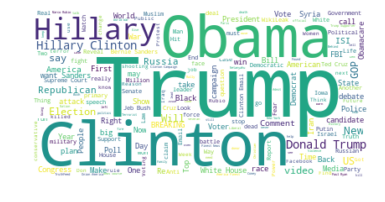

<Figure size 1440x720 with 0 Axes>

In [110]:

title_text = " ".join(title for title in df.title)
title_wordcloud = WordCloud(max_font_size=100,background_color="white").generate(title_text)
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure( figsize=(20,10) )
plt.show()
title_wordcloud.to_file("title.png")


In [111]:

### Wordcloud


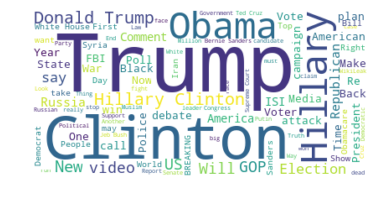

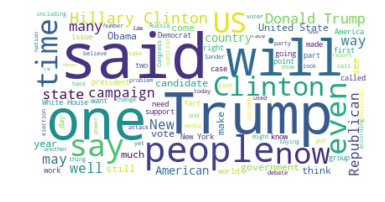

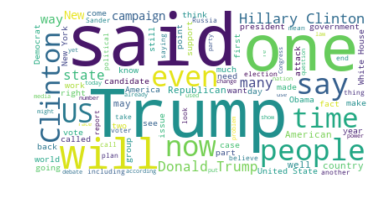

In [112]:

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#### Wordcloud for all titles

title_text = " ".join(title for title in df.title)
stopwords = set(STOPWORDS)
title_wordcloud = WordCloud(stopwords=stopwords,max_words=100, background_color="white").generate(title_text)
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
title_wordcloud.to_file("title.png")

#### Wordcloud for text
text = " ".join(text for text in df.text)
stopwords = set(STOPWORDS)
text_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(text)
plt.imshow(text_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
text_wordcloud.to_file("text.png")
#### Wordcloud for all

title_and_text = title_text + text
stopwords = set(STOPWORDS)
all_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_and_text)
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
text_wordcloud.to_file("all.png")